# Practico 2 - Redes Bayesianas y Estimación de distribuciones continuas.

El objetivo de esta notebook es implementar las redes bayesianas sobre el dataset de Tennis y continuar explorando formas de estimar distribuciones pero esta vez sobre datos continuos. 

## Parte 1: Redes Bayesianas

## Imports

In [1]:
!pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 4.9 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 5.7 MB/s eta 0:00:005.8 MB/s eta 0:00:01


In [10]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

### Paso 1: Cargar los Datos y Construir el Modelo

In [3]:
# Cargar los datos
data = pd.read_csv('./tennis.csv')
data.head()

,Day,Outlook,Temp,Humidity,Wind,Tennis
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes


Definimos variables aleatorias que vamos a usar. Por simplicidad en la visualización solo usaremos 3, pero puede usar todas las que quiera.

In [4]:
outlook = 'Outlook'
temp = 'Temp'
wind = 'Wind'
tennis = 'Tennis'

data = data[[outlook, temp, tennis]]

Tenemos que definir las relaciones condicionales que hay entre estas variables, para eso vamos a definir las siguientes relaciones: 

- Tennis depende de Outlook
- Tennis depende de Temp

In [5]:
relations = [(outlook, tennis), (temp, tennis)]

Teniendo las relaciones vamos a crear nuestro modelo!

In [11]:
model = DiscreteBayesianNetwork(relations)

Ahora que tenemos el modelo vamos a ajustarlo para que capture las probabilidades condicionales en las observaciones.

In [12]:
# Aprender los CPDs desde los datos
model.fit(data, estimator=MaximumLikelihoodEstimator)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Outlook': 'C', 'Temp': 'C', 'Tennis': 'C'}


Verificamos si el modelo es valido.

In [13]:
model.check_model()

True

### Paso 2: Visualización del Grafo y CPDs

In [14]:
def visualize_graph(model):
    G = nx.DiGraph()
    G.add_edges_from(model.edges())
    plt.figure(figsize=(7, 5))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=10000, node_color="skyblue", font_size=14, font_weight="bold", arrowsize=30)
    plt.title("Red Bayesiana del Dataset de Tenis")
    plt.show()

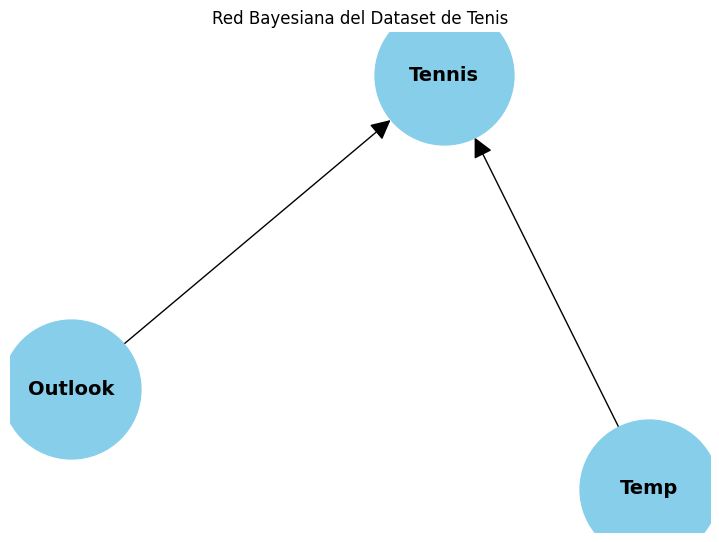

In [15]:
visualize_graph(model)

In [16]:
for cpd in model.get_cpds():
    print(f"CPD de {cpd.variable}:")
    print(cpd)

CPD de Outlook:
+-------------------+----------+
| Outlook(Overcast) | 0.285714 |
+-------------------+----------+
| Outlook(Rain)     | 0.357143 |
+-------------------+----------+
| Outlook(Sunny)    | 0.357143 |
+-------------------+----------+
CPD de Tennis:
+-------------+-------------------+-----+----------------+----------------+
| Outlook     | Outlook(Overcast) | ... | Outlook(Sunny) | Outlook(Sunny) |
+-------------+-------------------+-----+----------------+----------------+
| Temp        | Temp(Cool)        | ... | Temp(Hot)      | Temp(Mild)     |
+-------------+-------------------+-----+----------------+----------------+
| Tennis(No)  | 0.0               | ... | 1.0            | 0.5            |
+-------------+-------------------+-----+----------------+----------------+
| Tennis(Yes) | 1.0               | ... | 0.0            | 0.5            |
+-------------+-------------------+-----+----------------+----------------+
CPD de Temp:
+------------+----------+
| Temp(Cool) | 

### Explicación:
- **Estructura de la Red:** Los arcos en la red representan la relación de causa y efecto entre las variables. Aquí, las condiciones del clima influyen en la decisión de jugar tenis.
- **CPDs:** Cada nodo tiene un CPD que describe la distribución de probabilidad condicional de la variable dada sus padres.

¿Por qué la tabla de Outlook y Temp solamente una columna mientras que la de Tennis tiene varias?

¿Cuántas columnas tiene la de Tennis? ¿Por qué?

In [17]:
for cpd in model.get_cpds():
    print(f"Variable: {cpd.variable}")
    print("  Estados:")
    for state in cpd.state_names[cpd.variable]:
        print(f"    - {state}")
    print(f"  Cardinalidad: {cpd.variable_card}\n")

Variable: Outlook
  Estados:
    - Overcast
    - Rain
    - Sunny
  Cardinalidad: 3

Variable: Tennis
  Estados:
    - No
    - Yes
  Cardinalidad: 2

Variable: Temp
  Estados:
    - Cool
    - Hot
    - Mild
  Cardinalidad: 3



- **Cardinalidad:** Indica cuántos estados puede tener una variable.

### Paso 3: Inferencia en la Red

**Inferencia:** Dado un conjunto de evidencias (ej. Outlook y Temp), la red calcula la probabilidad de que Tennis sea 'Yes' o 'No'.

In [18]:
# Inferencia en la red bayesiana
inferencia = VariableElimination(model)
resultado = inferencia.query(variables=[tennis], evidence={outlook: 'Sunny', temp: 'Mild'})
print("\nResultado de la inferencia:")
print(resultado)


Resultado de la inferencia:
+-------------+---------------+
| Tennis      |   phi(Tennis) |
+=============+===============+
| Tennis(No)  |        0.5000 |
+-------------+---------------+
| Tennis(Yes) |        0.5000 |
+-------------+---------------+


### Ejercicios:
1. Realice inferencias usando diferentes combinaciones de evidencias para observar cómo cambian las probabilidades.
2. Cree otro modelo con diferentes relaciones y realice inferencias sobre este.
 Recuerde que puede agregar más variables (como por ej. Humudity o Wind).

## Parte 2: Estimando distribuciones continuas.

El objetivo de esta notebook es explorar una primera manera de aproximar $p(x|y)$ y $p(y|x)$ en un dataset tabular donde $x\in\mathbb{R}^k$ y el objetivo $y$ es una variable discreta y finita $y\in\{0,\ldots,d\}⊆\mathbb{N}, d\geq 1$.

### Imports

In [ ]:
import numpy as np
import seaborn as sns

from sklearn import datasets
from matplotlib import pyplot as plt

### Cargamos el dataset

In [ ]:
iris = datasets.load_iris()

In [ ]:
iris.target_names

In [ ]:
X = iris.data
y = iris.target

In [ ]:
iris_df = pd.DataFrame(data=X,
             columns=iris.feature_names,
             )

iris_df

Para simplificar el problema solo trabajaremos con una variable aleatoria.

Filtramos el dataset por feature.

feature_number puede ser 0, 1, 2, 3
- 0 - sepal length (cm)
- 1 - sepal width (cm)
- 2 - petal length (cm)
- 3 - petal width (cm)

In [ ]:
feature_number = 0
feature_name = iris.feature_names[feature_number]
xfeature_original = X[:,feature_number]
xfeature_original

Como estamos trabajando con valores continuos, vamos a discretizarlos.

Para ello, vamos a utilizar la funcion linspace de numpy, que nos permite dividir un rango en n partes iguales. https://numpy.org/doc/stable/reference/generated/numpy.linspace.html

Hacemos el siguiente calculo para tener la cantidad de bins que deseamos ya que la librería siempre nos crea uno más.

In [ ]:
NBINS = 10
bin_size = (np.max(xfeature_original) - np.min(xfeature_original)) / NBINS
end = np.max(xfeature_original) - bin_size
bins = np.linspace(start=np.min(xfeature_original), stop=end, num=NBINS)

bins

In [ ]:
xfeature_digitized = np.digitize(x=xfeature_original, bins=bins)
xfeature_digitized

### Aproximamos $p(x|y)$

Para calcular la distribución $p (x | y)$ usamos *distplot kde* (Kernel Density Estimation) para cada clase con los datos originales (datos continuos y no los discretizados).

Para este paso aprovechamos que el dataset esta ordenado por clase.

In [ ]:
pd_cats = pd.DataFrame(xfeature_original.flatten(), columns=['x'])
pd_cats['cat'] = np.concatenate((np.full(50, 'setosa'),
                                np.full(50, 'versicolor'),
                                np.full(50, 'virginica')))
sns.displot(
    data=pd_cats, x='x', kind='kde',
    hue='cat', fill=True
)

plt.title('p(x | y)')
plt.show()

¿Qué nos muestra esta gráfica?

¿Qué conclusiones puede sacar?

Ejercicio: Grafique un histograma para cada clase que nos muestre $p (bin| y = clase)$ utilizando los datos discretizados. Puede utilizar la función *np.histogram*. https://numpy.org/doc/stable/reference/generated/numpy.histogram.html

Luego compare los histogramas con la gráfica de arriba sobre $p (x | y)$.

### Aproximamos $p(y|x)$

Estime la probabilidad condicional de *y* dado *x* y luego muestree 10 valores de y dado que $x = 4.75$

### Sampleamos sobre *p(x|y)*

Realice una muestra de 50 valores de $x$ para cada valor de $y$. Recomendamos utilizar la función *gaussian_kde* de *scipy.stats*.

In [ ]:
from scipy.stats import gaussian_kde


Grafique $p(x|y)$ utilizando los datos sampleados y compare con la gráfica de $p(x|y)$ creada con los datos originales.

### Aproximamos la distribución normal de $p(x|y)$

In [ ]:
# Separamos los datos de cada clase
setosa_feature = xfeature_original[:50]
versicolor_feature = xfeature_original[51:100]
virginica_feature = xfeature_original[101:150]

Calcule la media y la desviación estándar para cada valor de $y$.

Utilice la función *normal* de *np.random* para realizar una muestra sobre cada distribución normal.

Utilizando las muestras grafique la aproximación a distribuciones normales de *p (x | y)*.

Compare esta gráfica con la gráfica de *p(x|y)* original.

### Graficamos la mezcla de Gaussianas.

Grafique la mezcla de Gaussianas.

Compare esta gráfica con la gráfica de *p(x|y)* usando distribuciones normales.

### Opcional: Aproxime $p(y|x)$ y realice una muestra de 10 valores de $y$ con $x = 4.75$